# Using Contextual Bradley-Terry for LMArena Style Control Leaderboard

This notebook processes the [`arena-human-preference-140k`](https://huggingface.co/datasets/lmarena-ai/arena-human-preference-140k) dataset to compute a leaderboard using a Contextual Bradley-Terry model, which controls for style elements in AI chat responses. This is the methodology used on the text leaderboard with style control. A full description is in our blog post: [Does style matter? Disentangling style and substance in Chatbot Arena](https://lmsys.org/blog/2024-08-28-style-control/).

We will:
1. Load the dataset.
2. Extract and normalize linguistic features (token count, bold usage, etc.).
3. Train the Contextual Bradley-Terry model using the `arena` package
4. Examine the style coefficients and plot the leaderboard and with confidence intervals.

In [16]:
import datasets
import pandas as pd
import matplotlib.pyplot as plt

from arena.utils.data_utils import ContextualPairDataset
from arena.models.contextual_bradley_terry import ContextualBradleyTerry

### Style Feature Preprocessing
We use 4 style features, the counts of tokens, lists, headers, and bold elements. We preprocess the features to be relative differences rather than absolute differences, and normalize over the dataset.

In [21]:
def extract_metadata_features(df):
    """Extracts nested metadata dictionaries into top-level columns."""
    feature_map = {
        "sum_assistant_a_tokens": "sum_assistant_tokens_a",
        "sum_assistant_b_tokens": "sum_assistant_tokens_b",
    }
    # for dictionary columns (like header_count), sum the values
    for key in ["header_count", "bold_count", "list_count"]:
        for suffix in ["_a", "_b"]:
            col_name = f"{key}{suffix}"
            df[col_name] = df["conv_metadata"].apply(
                lambda x: sum(x[col_name].values()) if isinstance(x[col_name], dict) else 0
            )

    for old, new in feature_map.items():
        df[new] = df["conv_metadata"].apply(lambda x: x[old])
    return df


def add_feature_cols(df, feature_names):
    """computes normalized relative differences for the style features."""
    for feature in feature_names:
        col_a, col_b = f"{feature}_a", f"{feature}_b"
        diff = df[col_a] - df[col_b]
        total = df[col_a] + df[col_b]
        total = total.replace(0, 1)
        df[feature + "_raw"] = diff / total
        df[feature] = (df[feature + "_raw"] - df[feature + "_raw"].mean()) / df[feature + "_raw"].std()

    return df


dataset = datasets.load_dataset(
    "lmarena-ai/arena-human-preference-140k",
    columns=["model_a", "model_b", "winner", "conv_metadata"],
    split="train",
)
df = dataset.to_pandas()

df = extract_metadata_features(df)
feature_cols = ["sum_assistant_tokens", "header_count", "bold_count", "list_count"]
df = add_feature_cols(df, feature_cols)
df = df[["model_a", "model_b", "winner"] + feature_cols + [f + "_raw" for f in feature_cols]]

print(f"Processed {len(df)} rows.")
df.head()

Processed 135634 rows.


,model_a,model_b,winner,sum_assistant_tokens,header_count,bold_count,list_count,sum_assistant_tokens_raw,header_count_raw,bold_count_raw,list_count_raw
0,gemini-2.5-pro,claude-3-7-sonnet-20250219-thinking-32k,model_a,1.944768,1.208257,1.309957,1.757552,0.750708,0.777778,0.857143,1.000000
1,claude-3-5-haiku-20241022,claude-3-5-sonnet-20241022,tie,0.504124,1.554152,1.529277,1.086202,0.195652,1.000000,1.000000,0.619048
2,o3-mini,gemma-3n-e4b-it,both_bad,0.079100,-0.002373,-0.795110,-1.263523,0.031898,0.000000,-0.514019,-0.714286
3,claude-sonnet-4-20250514-thinking-32k,gemini-2.5-pro,model_a,-1.343709,-1.558897,-0.753905,-0.592173,-0.516287,-1.000000,-0.487179,-0.333333
4,claude-3-5-sonnet-20241022,mistral-medium-2505,model_b,-1.232194,-1.558897,-1.541210,-0.036783,-0.473322,-1.000000,-1.000000,-0.018182


### Modeling
To use the `arena` package, we first instantiate a `ContextualPairDataset` object from out dataframe, this performs preprocessing and puts the data into a format useful for model fitting.

Second we create an instance of the `ContextualBradleyTerry` model class with the desired settings.

Finally we "train" the model, finding the ratings and feature coefficients via maximum likelihood estimation, and the confidence intervals using a [sandwich estimator](https://www.stat.umn.edu/geyer/5601/notes/sand.pdf).

In [18]:
context_dataset = ContextualPairDataset.from_pandas(
    df,
    competitor_cols=["model_a", "model_b"],
    outcome_col="winner",
    outcome_map={"model_a": 1.0, "model_b": 0.0, "tie": 0.5, "both_bad": 0.5},
    feature_cols=feature_cols,
    reweighted=True,
    min_pair_count=50,  # limits the impact of rarely seen pairs during reweighting
)

model = ContextualBradleyTerry(
    n_competitors=len(context_dataset.competitors),
    n_features=len(feature_cols),
)

# compute ratings and 95% confidence intervals
results = model.compute_ratings_and_cis(context_dataset, significance_level=0.05)

ratings = results["ratings"]
coeffs = results["coeffs"]
ci_lower = results["rating_lower"]
ci_upper = results["rating_upper"]
competitors = context_dataset.competitors

L-BFGS finished in 27 iterations.
  Final Loss: 0.666253
  Rel F Diff: 4.26e-07 (tol=1e-06)
  Grad Norm:  2.07e-04 (tol=1e-06)


In [19]:
# Create a dataframe for feature coefficients
coeff_df = pd.DataFrame({"Feature": feature_cols, "Coefficient": coeffs}).sort_values(by="Coefficient", ascending=False)

print("Feature Coefficients (Impact on Win Rate):")
display(coeff_df)

Feature Coefficients (Impact on Win Rate):


,Feature,Coefficient
0,sum_assistant_tokens,0.038861
3,list_count,0.021793
2,bold_count,0.018961
1,header_count,0.017193


### Feature Interpretation
To understand the features let's imagine a scenario where two models gave responses, one with 2000, tokens and one with 1000, with all other features being equal. The feature value would be (2000 - 1000) / (2000 + 1000) = 0.3333. The normalization will depend on the distributional statistics of the dataset you are working with, but let's say that after normalization, this feature is 0.75.

Then we can model the increase in the log-odds of the first model being chosen due to the token difference as 0.75 * 0.03886 = 0.0291. Then converting to Elo rating scale we can do 0.0291 * (400 / log(10)) = 5.0631. So this token difference is equivalent to about a 5 point score difference.

### Leaderboard Visualization
We can plot the ratings and confidence intervals and recover a leaderboard representing the style-controlled strengths as of July 2025 when this public dataset was released.

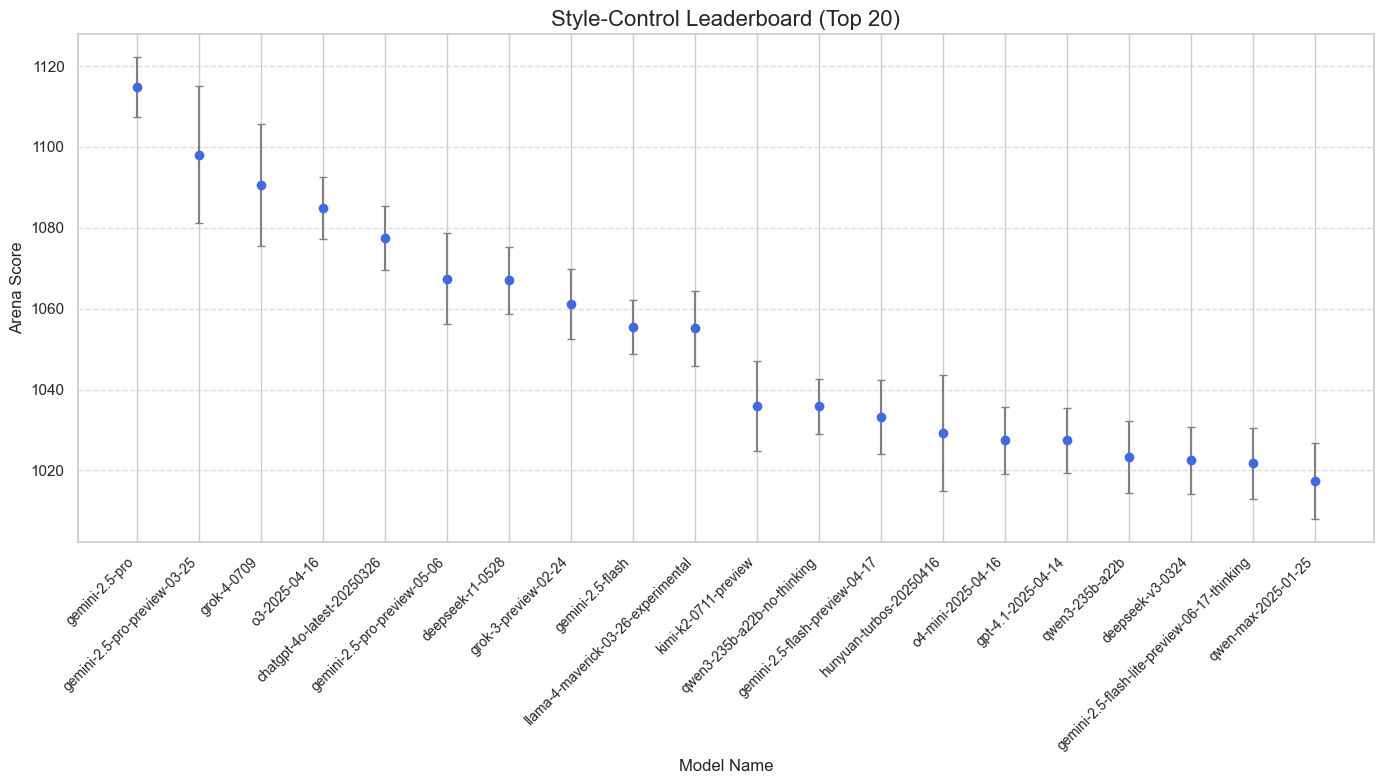

In [23]:
leaderboard_df = pd.DataFrame({"Model": competitors, "Rating": ratings, "Lower": ci_lower, "Upper": ci_upper})

# sort by rating
leaderboard_df = leaderboard_df.sort_values(by="Rating", ascending=False).reset_index(drop=True)

# calculate error bar sizes
leaderboard_df["error_lower"] = leaderboard_df["Rating"] - leaderboard_df["Lower"]
leaderboard_df["error_upper"] = leaderboard_df["Upper"] - leaderboard_df["Rating"]

top_n = 20
plot_df = leaderboard_df.head(top_n)

plt.figure(figsize=(14, 8))
plt.errorbar(
    x=plot_df["Model"],
    y=plot_df["Rating"],
    yerr=[plot_df["error_lower"], plot_df["error_upper"]],
    fmt="o",
    color="royalblue",
    ecolor="gray",
    capsize=3,
    markersize=6,
)

plt.title(f"Style-Control Leaderboard (Top {top_n})", fontsize=16)
plt.ylabel("Arena Score", fontsize=12)
plt.xlabel("Model Name", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()